In [1]:
import torch
import torchvision
import torchvision.datasets as dataset
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Model

In [2]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self,input_dim,h_dim,z_dim):
    super(VariationalAutoEncoder, self).__init__()

    #encoder
    self.img_2hid = nn.Linear(input_dim, h_dim)
    self.hid_2mu = nn.Linear(h_dim,z_dim)
    self.hid_2sigma = nn.Linear(h_dim,z_dim)

    #decoder
    self.z_2hid = nn.Linear(z_dim,h_dim)
    self.hid_2img = nn.Linear(h_dim,input_dim)

    self.relu = nn.ReLU()

  def encoder(self,x):
      h = self.relu(self.img_2hid(x))
      mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
      return mu, sigma

  def decoder(self,z):
      h = self.relu(self.z_2hid(z))
      return torch.sigmoid(self.hid_2img(h))

  def forward(self,x):
      mu, sigma = self.encoder(x)
      parameterizaion = mu + sigma*torch.randn_like(sigma)
      x_reconstructed = self.decoder(parameterizaion)
      return x_reconstructed, mu, sigma



# Dataset and Dataloader

In [3]:
dataset = dataset.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Train

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
EPOCH = 10
LR_RATE = 1e-4
INPUT_DIM = 784
H_DIM = 256
Z_DIM = 20

model = VariationalAutoEncoder(INPUT_DIM,H_DIM,Z_DIM)
loss_fn = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)



In [7]:
for i in range(EPOCH):
  loop = tqdm(enumerate(dataloader))
  for i,(x,y) in loop:
    x = x.view(x.shape[0],-1)
    x_reconstructed, mu, sigma = model(x)

    x_reconstructed = loss_fn(x_reconstructed,x)
    kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    loss = x_reconstructed + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())



1875it [00:27, 68.61it/s, loss=5.89e+3]
1875it [00:28, 66.65it/s, loss=5.08e+3]
1875it [00:28, 64.72it/s, loss=5.23e+3]
1875it [00:27, 68.41it/s, loss=4.84e+3]
1875it [00:27, 69.02it/s, loss=4.85e+3]
1875it [00:27, 69.25it/s, loss=4.91e+3]
1875it [00:27, 68.37it/s, loss=4.58e+3]
1875it [00:27, 69.21it/s, loss=4.86e+3]
1875it [00:26, 69.76it/s, loss=4.26e+3]
1875it [00:27, 69.35it/s, loss=4.22e+3]


#Inference

In [8]:
images = []
idx = 0
for x,y in dataset:
  if y == idx:
    images.append(x)

In [11]:
encodings_digit=[]
with torch.no_grad():
    mu, sigma = model.encoder(images[0].view(1, 784))
    encodings_digit.append((mu, sigma))

mu, sigma = encodings_digit[0]

epsilon = torch.randn_like(sigma)
z = mu + sigma * epsilon
out = model.decoder(z)
out = out.view(-1, 1, 28, 28)
save_image(out, f"generated_{0}_ex{0}.png")


In [12]:
print(out.shape)

torch.Size([1, 1, 28, 28])


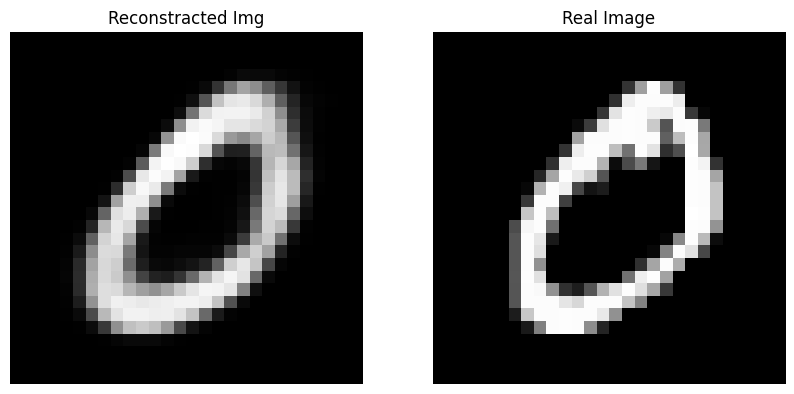

In [21]:
reconstracted_img = out.squeeze().detach().numpy()
img = images[0].squeeze().detach().numpy()
# Create a figure and specify the grid layout
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1st image
plt.imshow(reconstracted_img, cmap='gray')
plt.title("Reconstracted Img")
plt.axis('off')  # Turn off axis

# Plot the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2nd image
plt.imshow(img, cmap='gray')
plt.title("Real Image")
plt.axis('off')  # Turn off axis

# Show the plot
plt.show()

In [26]:
y,m,s = model(images[0].view(1, 784))
y = y.view(-1,1,28,28)


torch.Size([1, 1, 28, 28])


(-0.5, 27.5, 27.5, -0.5)

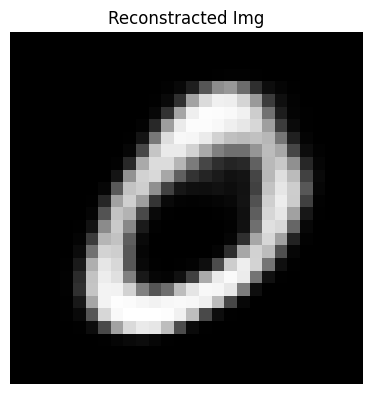

In [27]:
temp = y.squeeze().detach().numpy()
# Create a figure and specify the grid layout
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1st image
plt.imshow(temp, cmap='gray')
plt.title("Reconstracted Img")
plt.axis('off')  # Turn off axis
